In [3]:
# Cell 1: Installer les dépendances
!pip install optuna keras-tuner keras-tcn tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [5]:
# Cell 2: Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten,
    GRU, SimpleRNN, Dense, Dropout,
    MultiHeadAttention, Add, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.pruners import MedianPruner
import keras_tuner as kt
from tcn import TCN
import matplotlib.pyplot as plt


In [6]:
# Cell 3: Chargement et nettoyage des données
file_path = '/kaggle/input/dataset-ts/Padded Data TS Morocco.csv'
df = pd.read_csv(file_path)

# 1) Parser & indexer la date (renommer la première colonne en 'date' si nécessaire)
df.rename(columns={df.columns[0]: 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# 2) Nettoyer les colonnes numériques
num_cols = df.columns
df[num_cols] = (
    df[num_cols]
      .replace({' ': '', '\xa0': ''}, regex=True)
      .astype(float)
)

# 3) Imputation forward puis backward
df.ffill(inplace=True)
df.bfill(inplace=True)


In [7]:
# Cell 4: Feature engineering basique
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
df['dow_sin']   = np.sin(2 * np.pi * df.index.dayofweek / 7)
df['dow_cos']   = np.cos(2 * np.pi * df.index.dayofweek / 7)


In [8]:
# Cell 5: Split chronologique train / val / test
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]


In [9]:
# Cell 6: Scaling (fit sur train uniquement)
scaler = MinMaxScaler()
scaler.fit(train_df)

train_scaled = scaler.transform(train_df)
val_scaled   = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)


In [10]:
# Cell 7: Création des séquences temporelles
SEQ_LEN = 30

def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - SEQ_LEN):
        X.append(data[i : i + SEQ_LEN])
        y.append(data[i + SEQ_LEN])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_val,   y_val   = create_sequences(np.vstack([train_scaled[-SEQ_LEN:], val_scaled]))
X_test,  y_test  = create_sequences(np.vstack([val_scaled[-SEQ_LEN:], test_scaled]))

n_features = X_train.shape[2]


In [11]:
# Cell 8: Walk-Forward CV utilitaire
def walk_forward_cv(X, y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_idx, test_idx in tscv.split(X):
        yield X[train_idx], y[train_idx], X[test_idx], y[test_idx]


In [12]:
# Cell 9: Définition des fonctions de construction des 7 modèles

def build_lstm_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    layers   = trial.suggest_int("n_layers", 1, 3)

    model = Sequential([Input(shape=(SEQ_LEN, n_features))])
    for i in range(layers):
        return_seq = (i < layers - 1)
        model.add(LSTM(units, return_sequences=return_seq))
        model.add(Dropout(dropout))
    model.add(Dense(n_features, activation="linear"))
    model.compile("adam", "mse")
    return model

def build_bilstm_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    layers   = trial.suggest_int("n_layers", 1, 3)

    model = Sequential([Input(shape=(SEQ_LEN, n_features))])
    for i in range(layers):
        return_seq = (i < layers - 1)
        model.add(Bidirectional(LSTM(units, return_sequences=return_seq)))
        model.add(Dropout(dropout))
    model.add(Dense(n_features, activation="linear"))
    model.compile("adam", "mse")
    return model

def build_lstm_cnn_model(trial):
    lstm_units  = trial.suggest_int("lstm_units", 32, 256)
    cnn_filters = trial.suggest_int("cnn_filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(SEQ_LEN, n_features))
    x   = LSTM(lstm_units, return_sequences=True)(inp)
    x   = Conv1D(cnn_filters, kernel_size, activation="relu")(x)
    x   = MaxPooling1D()(x)
    x   = Flatten()(x)
    x   = Dropout(dropout)(x)
    out = Dense(n_features, activation="linear")(x)

    model = Model(inp, out)
    model.compile("adam", "mse")
    return model

def build_gru_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    layers   = trial.suggest_int("n_layers", 1, 3)

    model = Sequential([Input(shape=(SEQ_LEN, n_features))])
    for i in range(layers):
        return_seq = (i < layers - 1)
        model.add(GRU(units, return_sequences=return_seq))
        model.add(Dropout(dropout))
    model.add(Dense(n_features, activation="linear"))
    model.compile("adam", "mse")
    return model

def build_rnn_model(trial):
    units    = trial.suggest_int("units", 32, 256)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)
    layers   = trial.suggest_int("n_layers", 1, 3)

    model = Sequential([Input(shape=(SEQ_LEN, n_features))])
    for i in range(layers):
        return_seq = (i < layers - 1)
        model.add(SimpleRNN(units, return_sequences=return_seq))
        model.add(Dropout(dropout))
    model.add(Dense(n_features, activation="linear"))
    model.compile("adam", "mse")
    return model

def build_tcn_model(trial):
    filters     = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(SEQ_LEN, n_features))
    x   = TCN(nb_filters=filters, kernel_size=kernel_size, dilations=[1,2,4], dropout_rate=dropout)(inp)
    out = Dense(n_features, activation="linear")(x)

    model = Model(inp, out)
    model.compile("adam", "mse")
    return model

def build_transformer_model(trial):
    d_model   = trial.suggest_int("d_model", 32, 128)
    num_heads = trial.suggest_int("num_heads", 1, 4)
    ff_dim    = trial.suggest_int("ff_dim", 32, 128)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    inp = Input(shape=(SEQ_LEN, n_features))
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inp, inp)
    attn = Dropout(dropout)(attn)
    out1 = Add()([inp, attn])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn  = Dense(ff_dim, activation="relu")(out1)
    ffn  = Dense(n_features)(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization(epsilon=1e-6)(out2)

    flat = Flatten()(out2)
    output = Dense(n_features, activation="linear")(flat)
    model = Model(inp, output)
    model.compile("adam", "mse")
    return model


In [13]:
# Cell 10: Coarse tuning Optuna pour les 7 modèles
builders = {
    'LSTM':        build_lstm_model,
    'BiLSTM':      build_bilstm_model,
    'LSTM-CNN':    build_lstm_cnn_model,
    'GRU':         build_gru_model,
    'RNN':         build_rnn_model,
    'TCN':         build_tcn_model,
    'Transformer': build_transformer_model
}

best_params   = {}
best_values   = {}

for name, builder in builders.items():
    def objective(trial, builder=builder):
        cv_scores = []
        for split_idx, (X_tr, y_tr, X_te, y_te) in enumerate(walk_forward_cv(X_train, y_train), start=1):
            model = builder(trial)
            model.fit(
                X_tr, y_tr,
                validation_data=(X_te, y_te),
                epochs=30, batch_size=32,
                callbacks=[EarlyStopping("val_loss", patience=5, restore_best_weights=True)],
                verbose=0
            )
            preds = model.predict(X_te)
            score = mean_squared_error(y_te, preds)
            trial.report(score, split_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()
            cv_scores.append(score)
        return float(np.mean(cv_scores))

    study = optuna.create_study(direction="minimize", pruner=MedianPruner())
    study.optimize(objective, n_trials=20)
    best_params[name] = study.best_trial.params
    best_values[name] = study.best_value
    print(f"{name:12s} → MSE: {study.best_value:.5f}, params: {study.best_trial.params}")

best_model_name = min(best_values, key=best_values.get)
print(f"\nMeilleur modèle coarse : {best_model_name}")


[I 2025-05-05 02:37:40,314] A new study created in memory with name: no-name-b9b21a8e-2af2-4cc6-a85e-d2ecb0da4234
I0000 00:00:1746412661.927856      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746412661.928560      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1746412665.921180     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-05 02:37:58,869] Trial 0 finished with value: 0.02274709946898916 and parameters: {'units': 165, 'dropout': 0.11720135151487748, 'n_layers': 1}. Best is trial 0 with value: 0.02274709946898916.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-05 02:38:11,411] Trial 1 finished with value: 0.02293961513677877 and parameters: {'units': 241, 'dropout': 0.28511389103726376, 'n_layers': 1}. Best is trial 0 with value: 0.02274709946898916.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 02:38:24,582] Trial 2 finished with value: 0.02894353961888318 and parameters: {'units': 83, 'dropout': 0.47804350426291115, 'n_layers': 1}. Best is trial 0 with value: 0.02274709946898916.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-05 02:38:37,485] Trial 3 finished with value: 0.02589770908479155 and parameters: {'units': 68, 'dropout': 0.06141693235625412, 'n_layers': 1}. Best is trial 0 with value: 0.02274709946898916.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-05-05 02:38:56,339] Trial 4 finished with value: 0.025131266288299325 and parameters: {'units': 174, 'dropout': 0.23997870153145756, 'n_layers': 2}. Best is trial 0 with value: 0.02274709946898916.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


[I 2025-05-05 02:39:03,668] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


[I 2025-05-05 02:39:11,261] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


[I 2025-05-05 02:39:30,363] Trial 7 finished with value: 0.023984252339879126 and parameters: {'units': 156, 'dropout': 0.08350256414288781, 'n_layers': 2}. Best is trial 0 with value: 0.02274709946898916.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


[I 2025-05-05 02:39:36,632] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-05 02:39:42,223] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-05 02:39:56,041] Trial 10 finished with value: 0.02068585854344356 and parameters: {'units': 213, 'dropout': 0.18295133010546086, 'n_layers': 1}. Best is trial 10 with value: 0.02068585854344356.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-05 02:40:09,699] Trial 11 finished with value: 0.021282103993881796 and parameters: {'units': 220, 'dropout': 0.14859112595102236, 'n_layers': 1}. Best is trial 10 with value: 0.02068585854344356.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-05 02:40:23,619] Trial 12 finished with value: 0.019456963677765924 and parameters: {'units': 254, 'dropout': 0.15413933504645208, 'n_layers': 1}. Best is trial 12 with value: 0.019456963677765924.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-05 02:40:36,248] Trial 13 finished with value: 0.024354446170120073 and parameters: {'units': 256, 'dropout': 0.3625077382900559, 'n_layers': 1}. Best is trial 12 with value: 0.019456963677765924.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


[I 2025-05-05 02:40:42,017] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-05-05 02:40:55,829] Trial 15 finished with value: 0.016997063576212817 and parameters: {'units': 233, 'dropout': 0.0007189913862399588, 'n_layers': 1}. Best is trial 15 with value: 0.016997063576212817.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2025-05-05 02:41:09,750] Trial 16 finished with value: 0.017669864066151692 and parameters: {'units': 236, 'dropout': 0.005829488827244517, 'n_layers': 1}. Best is trial 15 with value: 0.016997063576212817.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


[I 2025-05-05 02:41:17,644] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-05 02:41:30,872] Trial 18 finished with value: 0.0188310461208097 and parameters: {'units': 230, 'dropout': 0.06996510400547928, 'n_layers': 1}. Best is trial 15 with value: 0.016997063576212817.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


[I 2025-05-05 02:41:37,124] Trial 19 pruned. 
[I 2025-05-05 02:41:37,125] A new study created in memory with name: no-name-c75b27b9-946f-48a2-91d0-05c58fd71277


LSTM         → MSE: 0.01700, params: {'units': 233, 'dropout': 0.0007189913862399588, 'n_layers': 1}
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 725ms/step


[I 2025-05-05 02:42:15,143] Trial 0 finished with value: 0.027496607096007597 and parameters: {'units': 72, 'dropout': 0.49747915234274437, 'n_layers': 3}. Best is trial 0 with value: 0.027496607096007597.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


[I 2025-05-05 02:42:43,527] Trial 1 finished with value: 0.020623204873430643 and parameters: {'units': 228, 'dropout': 0.3469689998944583, 'n_layers': 2}. Best is trial 1 with value: 0.020623204873430643.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step


[I 2025-05-05 02:43:26,395] Trial 2 finished with value: 0.01939561921165761 and parameters: {'units': 248, 'dropout': 0.08200879360598262, 'n_layers': 3}. Best is trial 2 with value: 0.01939561921165761.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


[I 2025-05-05 02:43:45,672] Trial 3 finished with value: 0.020609939411449688 and parameters: {'units': 176, 'dropout': 0.2858367284151137, 'n_layers': 1}. Best is trial 2 with value: 0.01939561921165761.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2025-05-05 02:44:13,902] Trial 4 finished with value: 0.024609591621106274 and parameters: {'units': 73, 'dropout': 0.2848926006062356, 'n_layers': 2}. Best is trial 2 with value: 0.01939561921165761.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 02:44:41,607] Trial 5 finished with value: 0.023126227798076566 and parameters: {'units': 85, 'dropout': 0.009821167146835397, 'n_layers': 2}. Best is trial 2 with value: 0.01939561921165761.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


[I 2025-05-05 02:44:46,932] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


[I 2025-05-05 02:44:52,448] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


[I 2025-05-05 02:44:59,040] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


[I 2025-05-05 02:45:04,405] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1000ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step


[I 2025-05-05 02:45:45,114] Trial 10 finished with value: 0.021332701223468514 and parameters: {'units': 252, 'dropout': 0.13193762898821093, 'n_layers': 3}. Best is trial 2 with value: 0.01939561921165761.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step  


[I 2025-05-05 02:46:25,453] Trial 11 finished with value: 0.022375761312545022 and parameters: {'units': 194, 'dropout': 0.35184564988274286, 'n_layers': 3}. Best is trial 2 with value: 0.01939561921165761.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step


[I 2025-05-05 02:47:05,671] Trial 12 finished with value: 0.01920038409296557 and parameters: {'units': 177, 'dropout': 0.1576435379114191, 'n_layers': 3}. Best is trial 12 with value: 0.01920038409296557.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step


[I 2025-05-05 02:47:17,558] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step


[I 2025-05-05 02:47:58,420] Trial 14 finished with value: 0.022590694817400985 and parameters: {'units': 256, 'dropout': 0.09878668989217079, 'n_layers': 3}. Best is trial 12 with value: 0.01920038409296557.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


[I 2025-05-05 02:48:38,742] Trial 15 finished with value: 0.021599097129220396 and parameters: {'units': 217, 'dropout': 0.17803345431458142, 'n_layers': 3}. Best is trial 12 with value: 0.01920038409296557.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step


[I 2025-05-05 02:49:06,239] Trial 16 finished with value: 0.020427333400737015 and parameters: {'units': 156, 'dropout': 0.04943721918266325, 'n_layers': 2}. Best is trial 12 with value: 0.01920038409296557.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step


[I 2025-05-05 02:49:47,128] Trial 17 finished with value: 0.0212333290564093 and parameters: {'units': 225, 'dropout': 0.07486687937511016, 'n_layers': 3}. Best is trial 12 with value: 0.01920038409296557.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 02:49:57,791] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step


[I 2025-05-05 02:50:09,211] Trial 19 pruned. 
[I 2025-05-05 02:50:09,212] A new study created in memory with name: no-name-09bc7c1c-7600-4072-94bf-d450efe0bb5e


BiLSTM       → MSE: 0.01920, params: {'units': 177, 'dropout': 0.1576435379114191, 'n_layers': 3}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


[I 2025-05-05 02:50:26,665] Trial 0 finished with value: 0.023853179525497675 and parameters: {'lstm_units': 35, 'cnn_filters': 68, 'kernel_size': 4, 'dropout': 0.41454848762803687}. Best is trial 0 with value: 0.023853179525497675.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-05 02:50:41,253] Trial 1 finished with value: 0.0180774106329481 and parameters: {'lstm_units': 128, 'cnn_filters': 47, 'kernel_size': 5, 'dropout': 0.05074275700133718}. Best is trial 1 with value: 0.0180774106329481.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2025-05-05 02:50:55,766] Trial 2 finished with value: 0.016497732630293926 and parameters: {'lstm_units': 75, 'cnn_filters': 110, 'kernel_size': 4, 'dropout': 0.09909094627566528}. Best is trial 2 with value: 0.016497732630293926.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 02:51:13,034] Trial 3 finished with value: 0.01621026995898499 and parameters: {'lstm_units': 234, 'cnn_filters': 124, 'kernel_size': 4, 'dropout': 0.1590032971482081}. Best is trial 3 with value: 0.01621026995898499.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-05 02:51:27,632] Trial 4 finished with value: 0.01724637898485536 and parameters: {'lstm_units': 133, 'cnn_filters': 58, 'kernel_size': 3, 'dropout': 0.0993440932496017}. Best is trial 3 with value: 0.01621026995898499.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 02:51:32,210] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


[I 2025-05-05 02:51:49,036] Trial 6 finished with value: 0.016362258474672393 and parameters: {'lstm_units': 120, 'cnn_filters': 122, 'kernel_size': 4, 'dropout': 0.2579237930100157}. Best is trial 3 with value: 0.01621026995898499.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2025-05-05 02:51:53,562] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-05 02:51:58,048] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-05 02:52:07,601] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-05 02:52:12,092] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


[I 2025-05-05 02:52:29,347] Trial 11 finished with value: 0.015931269924964804 and parameters: {'lstm_units': 250, 'cnn_filters': 120, 'kernel_size': 3, 'dropout': 0.20142738644261993}. Best is trial 11 with value: 0.015931269924964804.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 02:52:34,266] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-05 02:52:48,882] Trial 13 finished with value: 0.016052760008196863 and parameters: {'lstm_units': 202, 'cnn_filters': 105, 'kernel_size': 3, 'dropout': 0.16797593249656742}. Best is trial 11 with value: 0.015931269924964804.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-05 02:53:03,953] Trial 14 finished with value: 0.01412690118688828 and parameters: {'lstm_units': 199, 'cnn_filters': 103, 'kernel_size': 3, 'dropout': 0.006113587739243365}. Best is trial 14 with value: 0.01412690118688828.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-05 02:53:08,571] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-05 02:53:26,013] Trial 16 finished with value: 0.015665159332114275 and parameters: {'lstm_units': 206, 'cnn_filters': 111, 'kernel_size': 3, 'dropout': 0.1014340489532168}. Best is trial 14 with value: 0.01412690118688828.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


[I 2025-05-05 02:53:30,554] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-05 02:53:35,165] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-05 02:53:39,768] Trial 19 pruned. 
[I 2025-05-05 02:53:39,769] A new study created in memory with name: no-name-dcf5b4db-5f37-463d-a495-ca3724c836f9


LSTM-CNN     → MSE: 0.01413, params: {'lstm_units': 199, 'cnn_filters': 103, 'kernel_size': 3, 'dropout': 0.006113587739243365}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-05 02:53:51,355] Trial 0 finished with value: 0.0330983769195666 and parameters: {'units': 32, 'dropout': 0.31823848467094396, 'n_layers': 1}. Best is trial 0 with value: 0.0330983769195666.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


[I 2025-05-05 02:54:10,547] Trial 1 finished with value: 0.016197905556532027 and parameters: {'units': 161, 'dropout': 0.11112170547622285, 'n_layers': 2}. Best is trial 1 with value: 0.016197905556532027.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-05 02:54:26,842] Trial 2 finished with value: 0.015390075619428192 and parameters: {'units': 156, 'dropout': 0.005742570727940377, 'n_layers': 2}. Best is trial 2 with value: 0.015390075619428192.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2025-05-05 02:54:39,080] Trial 3 finished with value: 0.017961023043573752 and parameters: {'units': 134, 'dropout': 0.24791913361895634, 'n_layers': 1}. Best is trial 2 with value: 0.015390075619428192.


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


[I 2025-05-05 02:54:57,248] Trial 4 finished with value: 0.022684922561343513 and parameters: {'units': 155, 'dropout': 0.4090930851159925, 'n_layers': 2}. Best is trial 2 with value: 0.015390075619428192.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


[I 2025-05-05 02:55:02,380] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[I 2025-05-05 02:55:07,536] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2025-05-05 02:55:11,225] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


[I 2025-05-05 02:55:16,559] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


[I 2025-05-05 02:55:21,645] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


[I 2025-05-05 02:55:30,992] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


[I 2025-05-05 02:55:37,906] Trial 11 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-05-05 02:55:44,735] Trial 12 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


[I 2025-05-05 02:56:00,672] Trial 13 finished with value: 0.015245205533690178 and parameters: {'units': 254, 'dropout': 0.0011765001574471357, 'n_layers': 2}. Best is trial 13 with value: 0.015245205533690178.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-05 02:56:15,080] Trial 14 finished with value: 0.015174178673364116 and parameters: {'units': 233, 'dropout': 0.007989602504244816, 'n_layers': 1}. Best is trial 14 with value: 0.015174178673364116.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2025-05-05 02:56:23,042] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2025-05-05 02:56:31,066] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2025-05-05 02:56:38,882] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


[I 2025-05-05 02:56:45,650] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2025-05-05 02:56:57,605] Trial 19 finished with value: 0.014950713593114659 and parameters: {'units': 233, 'dropout': 0.07149001245896078, 'n_layers': 1}. Best is trial 19 with value: 0.014950713593114659.
[I 2025-05-05 02:56:57,606] A new study created in memory with name: no-name-d6592b4f-15f3-4007-b211-30f60bf0d277


GRU          → MSE: 0.01495, params: {'units': 233, 'dropout': 0.07149001245896078, 'n_layers': 1}


I0000 00:00:1746413819.358594     112 service.cc:148] XLA service 0x29726100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746413819.361761     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746413819.361782     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746413820.895588     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-05-05 02:57:21,488] Trial 0 finished with value: 0.022364780482125188 and parameters: {'units': 178, 'dropout': 0.23464583441272918, 'n_layers': 1}. Best is trial 0 with value: 0.022364780482125188.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step


[I 2025-05-05 02:57:54,578] Trial 1 finished with value: 0.02640129760200487 and parameters: {'units': 190, 'dropout': 0.10288651824213346, 'n_layers': 2}. Best is trial 0 with value: 0.022364780482125188.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step


[I 2025-05-05 02:58:26,582] Trial 2 finished with value: 0.03250233100108534 and parameters: {'units': 85, 'dropout': 0.11177933956192232, 'n_layers': 2}. Best is trial 0 with value: 0.022364780482125188.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


[I 2025-05-05 02:59:09,117] Trial 3 finished with value: 0.030578911503363938 and parameters: {'units': 76, 'dropout': 0.07756736910629702, 'n_layers': 3}. Best is trial 0 with value: 0.022364780482125188.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step


[I 2025-05-05 02:59:42,327] Trial 4 finished with value: 0.033111068480380076 and parameters: {'units': 131, 'dropout': 0.384525593253615, 'n_layers': 2}. Best is trial 0 with value: 0.022364780482125188.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


[I 2025-05-05 03:00:05,957] Trial 5 finished with value: 0.01890839250614455 and parameters: {'units': 243, 'dropout': 0.19403334920171034, 'n_layers': 1}. Best is trial 5 with value: 0.01890839250614455.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-05-05 03:00:48,184] Trial 6 finished with value: 0.02203502764231517 and parameters: {'units': 173, 'dropout': 0.04493301718695103, 'n_layers': 3}. Best is trial 5 with value: 0.01890839250614455.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2025-05-05 03:01:02,002] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


[I 2025-05-05 03:01:26,404] Trial 8 finished with value: 0.0196512813525332 and parameters: {'units': 250, 'dropout': 0.31672817568582773, 'n_layers': 1}. Best is trial 5 with value: 0.01890839250614455.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


[I 2025-05-05 03:01:33,374] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


[I 2025-05-05 03:01:54,129] Trial 10 finished with value: 0.020828181651718302 and parameters: {'units': 255, 'dropout': 0.48463686886280233, 'n_layers': 1}. Best is trial 5 with value: 0.01890839250614455.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2025-05-05 03:02:15,058] Trial 11 finished with value: 0.019903761468816016 and parameters: {'units': 252, 'dropout': 0.23790470354035215, 'n_layers': 1}. Best is trial 5 with value: 0.01890839250614455.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


[I 2025-05-05 03:02:35,339] Trial 12 finished with value: 0.022046042290716245 and parameters: {'units': 228, 'dropout': 0.3110011765232713, 'n_layers': 1}. Best is trial 5 with value: 0.01890839250614455.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


[I 2025-05-05 03:02:42,352] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step  


[I 2025-05-05 03:02:57,267] Trial 14 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


[I 2025-05-05 03:03:07,928] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


[I 2025-05-05 03:03:14,936] Trial 16 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2025-05-05 03:03:21,816] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


[I 2025-05-05 03:03:28,781] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step


[I 2025-05-05 03:03:39,870] Trial 19 pruned. 
[I 2025-05-05 03:03:39,871] A new study created in memory with name: no-name-32023362-c2b4-4095-9873-d50dd2f95c6f


RNN          → MSE: 0.01891, params: {'units': 243, 'dropout': 0.19403334920171034, 'n_layers': 1}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2025-05-05 03:04:26,643] Trial 0 finished with value: 0.08916681733791211 and parameters: {'filters': 36, 'kernel_size': 3, 'dropout': 0.43265538736593356}. Best is trial 0 with value: 0.08916681733791211.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2025-05-05 03:05:17,554] Trial 1 finished with value: 0.044429578346525396 and parameters: {'filters': 82, 'kernel_size': 2, 'dropout': 0.2285762457659276}. Best is trial 1 with value: 0.044429578346525396.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 03:06:04,705] Trial 2 finished with value: 0.0564511736914507 and parameters: {'filters': 97, 'kernel_size': 2, 'dropout': 0.35789250788618326}. Best is trial 1 with value: 0.044429578346525396.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-05-05 03:06:55,511] Trial 3 finished with value: 0.06452356796836502 and parameters: {'filters': 57, 'kernel_size': 5, 'dropout': 0.4085904913246047}. Best is trial 1 with value: 0.044429578346525396.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step


[I 2025-05-05 03:07:42,694] Trial 4 finished with value: 0.02941622469128825 and parameters: {'filters': 55, 'kernel_size': 4, 'dropout': 0.03575250609348862}. Best is trial 4 with value: 0.02941622469128825.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-05-05 03:08:33,063] Trial 5 finished with value: 0.030396319312241866 and parameters: {'filters': 49, 'kernel_size': 5, 'dropout': 0.07676149770310309}. Best is trial 4 with value: 0.02941622469128825.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step


[I 2025-05-05 03:09:19,851] Trial 6 finished with value: 0.03348279673677875 and parameters: {'filters': 94, 'kernel_size': 3, 'dropout': 0.2161686002092179}. Best is trial 4 with value: 0.02941622469128825.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-05-05 03:09:36,211] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-05-05 03:09:52,248] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-05-05 03:10:08,339] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-05-05 03:10:28,478] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-05-05 03:11:15,876] Trial 11 finished with value: 0.031063107581497728 and parameters: {'filters': 40, 'kernel_size': 5, 'dropout': 0.020097219601861116}. Best is trial 4 with value: 0.02941622469128825.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


[I 2025-05-05 03:12:03,554] Trial 12 finished with value: 0.03579007038997764 and parameters: {'filters': 47, 'kernel_size': 4, 'dropout': 0.10308019172829602}. Best is trial 4 with value: 0.02941622469128825.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2025-05-05 03:12:19,294] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2025-05-05 03:13:08,910] Trial 14 finished with value: 0.030673846680231574 and parameters: {'filters': 55, 'kernel_size': 4, 'dropout': 0.08452099764574837}. Best is trial 4 with value: 0.02941622469128825.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2025-05-05 03:13:25,107] Trial 15 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-05-05 03:14:12,596] Trial 16 finished with value: 0.031579995012316946 and parameters: {'filters': 81, 'kernel_size': 4, 'dropout': 0.16990733721080103}. Best is trial 4 with value: 0.02941622469128825.


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step


[I 2025-05-05 03:14:32,853] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-05-05 03:15:21,643] Trial 18 finished with value: 0.018383918931178456 and parameters: {'filters': 124, 'kernel_size': 5, 'dropout': 0.07954433349309264}. Best is trial 18 with value: 0.018383918931178456.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2025-05-05 03:16:09,875] Trial 19 finished with value: 0.022373428160296766 and parameters: {'filters': 123, 'kernel_size': 4, 'dropout': 0.16125304575646726}. Best is trial 18 with value: 0.018383918931178456.
[I 2025-05-05 03:16:09,876] A new study created in memory with name: no-name-65f7ac2c-4964-4ac5-a342-c9177a6d7a1d


TCN          → MSE: 0.01838, params: {'filters': 124, 'kernel_size': 5, 'dropout': 0.07954433349309264}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 03:16:54,482] Trial 0 finished with value: 0.038320927447406325 and parameters: {'d_model': 33, 'num_heads': 4, 'ff_dim': 83, 'dropout': 0.2067633804372231}. Best is trial 0 with value: 0.038320927447406325.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step


[I 2025-05-05 03:17:33,878] Trial 1 finished with value: 0.029456423463410587 and parameters: {'d_model': 99, 'num_heads': 4, 'ff_dim': 67, 'dropout': 0.11581470145064332}. Best is trial 1 with value: 0.029456423463410587.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step


[I 2025-05-05 03:18:10,780] Trial 2 finished with value: 0.053734034705937996 and parameters: {'d_model': 96, 'num_heads': 2, 'ff_dim': 67, 'dropout': 0.4869309975930671}. Best is trial 1 with value: 0.029456423463410587.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-05-05 03:18:55,016] Trial 3 finished with value: 0.047061651999855326 and parameters: {'d_model': 115, 'num_heads': 2, 'ff_dim': 34, 'dropout': 0.26517849908733265}. Best is trial 1 with value: 0.029456423463410587.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step


[I 2025-05-05 03:19:33,756] Trial 4 finished with value: 0.03300834515547365 and parameters: {'d_model': 82, 'num_heads': 2, 'ff_dim': 54, 'dropout': 0.03306041814217037}. Best is trial 1 with value: 0.029456423463410587.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


[I 2025-05-05 03:19:46,764] Trial 5 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


[I 2025-05-05 03:20:00,017] Trial 6 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2025-05-05 03:20:13,763] Trial 7 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


[I 2025-05-05 03:20:27,033] Trial 8 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2025-05-05 03:20:40,179] Trial 9 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2025-05-05 03:21:11,996] Trial 10 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


[I 2025-05-05 03:21:51,191] Trial 11 finished with value: 0.02970723225953627 and parameters: {'d_model': 91, 'num_heads': 3, 'ff_dim': 54, 'dropout': 0.021923516332381376}. Best is trial 1 with value: 0.029456423463410587.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


[I 2025-05-05 03:22:29,951] Trial 12 finished with value: 0.031024831336896323 and parameters: {'d_model': 92, 'num_heads': 3, 'ff_dim': 79, 'dropout': 0.10342790024057663}. Best is trial 1 with value: 0.029456423463410587.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-05-05 03:22:43,789] Trial 13 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


[I 2025-05-05 03:23:28,305] Trial 14 finished with value: 0.02844141888528429 and parameters: {'d_model': 98, 'num_heads': 4, 'ff_dim': 72, 'dropout': 0.0029336199861649537}. Best is trial 14 with value: 0.02844141888528429.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2025-05-05 03:24:08,777] Trial 15 finished with value: 0.02559869922261355 and parameters: {'d_model': 126, 'num_heads': 4, 'ff_dim': 78, 'dropout': 0.016145786925664127}. Best is trial 15 with value: 0.02559869922261355.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


[I 2025-05-05 03:24:48,930] Trial 16 finished with value: 0.026196017239592 and parameters: {'d_model': 127, 'num_heads': 4, 'ff_dim': 86, 'dropout': 0.00593119744440181}. Best is trial 15 with value: 0.02559869922261355.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-05-05 03:25:02,592] Trial 17 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-05-05 03:25:28,380] Trial 18 pruned. 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


[I 2025-05-05 03:26:00,266] Trial 19 pruned. 


Transformer  → MSE: 0.02560, params: {'d_model': 126, 'num_heads': 4, 'ff_dim': 78, 'dropout': 0.016145786925664127}

Meilleur modèle coarse : LSTM-CNN


In [14]:
# Cell 11: Fine-tuning Hyperband pour le meilleur modèle
def model_builder(hp):
    params = best_params[best_model_name]
    # Exemple LSTM; adaptez si best_model_name != "LSTM"
    units   = hp.Int("units", 32, 256, step=32, default=params.get("units", 64))
    dropout = hp.Float("dropout", 0.0, 0.5, default=params.get("dropout", 0.1))
    layers  = hp.Int("n_layers", 1, 3, default=params.get("n_layers", 1))

    inp = Input(shape=(SEQ_LEN, n_features))
    x   = inp
    for i in range(layers):
        return_seq = (i < layers - 1)
        x = LSTM(units, return_sequences=return_seq)(x)
        x = Dropout(dropout)(x)
    out = Dense(n_features, activation="linear")(x)
    model = Model(inp, out)
    model.compile("adam", "mse")
    return model

tuner = kt.Hyperband(
    model_builder,
    objective="val_loss",
    max_epochs=50,
    factor=3,
    directory="hyperband",
    project_name="fine_tune"
)
tuner.search(
    np.vstack([X_train, X_val]),
    np.vstack([y_train, y_val]),
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping("val_loss", 5, True)],
    verbose=1
)
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperband HP :", best_hp.values)


Trial 90 Complete [00h 00m 15s]
val_loss: 0.09878130257129669

Best val_loss So Far: 0.0654253214597702
Total elapsed time: 00h 21m 07s
Best Hyperband HP : {'units': 160, 'dropout': 0.1645517806862235, 'n_layers': 1, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0048'}


In [15]:
# Cell 12: Entraînement final & ensembling
final_models = {}
for name, builder in builders.items():
    params = best_params[name]
    model  = builder(optuna.trial.FixedTrial(params))
    model.fit(
        np.vstack([X_train, X_val]),
        np.vstack([y_train, y_val]),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping("val_loss", 5, True)],
        verbose=0
    )
    final_models[name] = model

# Ensembling : moyenne des prédictions des 3 meilleurs selon MSE coarse
top3 = sorted(best_values, key=best_values.get)[:3]
print("Top 3 modèles :", top3)

preds_ensemble = np.mean(
    [final_models[n].predict(X_test) for n in top3],
    axis=0
)


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


Top 3 modèles : ['LSTM-CNN', 'GRU', 'LSTM']
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [16]:
# Cell 13: Calcul des métriques en excluant les zéros
y_true = scaler.inverse_transform(y_test)
preds   = scaler.inverse_transform(preds_ensemble)

# Global
mask   = y_true.flatten() != 0
mse_g  = mean_squared_error(y_true.flatten()[mask], preds.flatten()[mask])
mae_g  = mean_absolute_error(y_true.flatten()[mask], preds.flatten()[mask])
print(f"Ensemble global → MSE: {mse_g:.4f}, MAE: {mae_g:.4f}\n")

# Par indicateur
for i, col in enumerate(df.columns):
    y_col = y_true[:, i]; p_col = preds[:, i]
    mask_col = y_col != 0
    if mask_col.any():
        mse_c = mean_squared_error(y_col[mask_col], p_col[mask_col])
        mae_c = mean_absolute_error(y_col[mask_col], p_col[mask_col])
        print(f"{col:20s} → MSE: {mse_c:.4f}, MAE: {mae_c:.4f}")
    else:
        print(f"{col:20s} → Tous zéros (skip)")


Ensemble global → MSE: 3564478523244676644864.0000, MAE: 6685361909.8263

IDE(USD)             → MSE: 892220779583146496.0000, MAE: 896215969.9530
REER(2010 = 100)     → MSE: 106.4599, MAE: 8.6607
brent_oil_prices(USD/barrel) → MSE: 520.1576, MAE: 16.7258
crude_oil_prices(USD/barrel) → MSE: 242.1465, MAE: 12.2843
daily_natural_gas_prices(USD/MMBtu) → MSE: 1.7291, MAE: 1.0622
annual_gold_prices(USD/oz) → MSE: 67298.8809, MAE: 230.0484
wheat_production (Million Bushels) → MSE: 218917.0651, MAE: 394.1586
InterTourismeReceipts(usd) → MSE: 5370863248711118848.0000, MAE: 2050580048.0000
Inflation, prix à la consommation (% annuel) → MSE: 9.2547, MAE: 1.7027
Chômage, total (% de la population) → MSE: 2.5209, MAE: 1.1237
Chômage, total jeune entre 15-24  (% de la population) → MSE: 15.7827, MAE: 3.0579
Demographie          → MSE: 139517326.4960, MAE: 7767.1465
Pauvrete             → MSE: 12.0006, MAE: 2.9499
Analphabetisme       → MSE: 129.9293, MAE: 9.6121
Consommation finals des ménages → MS

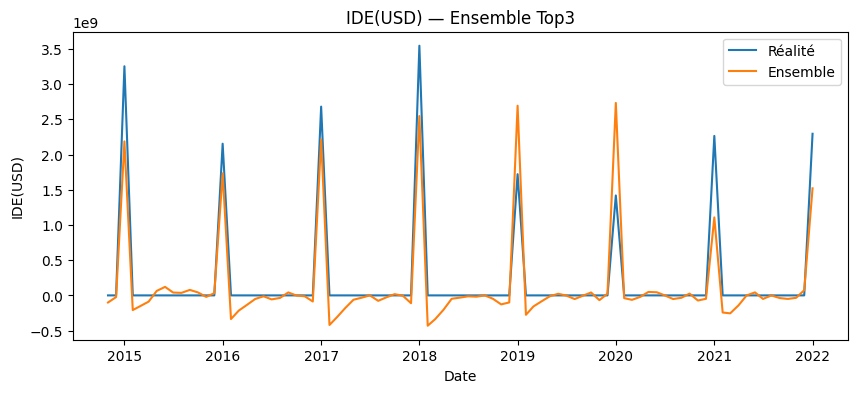

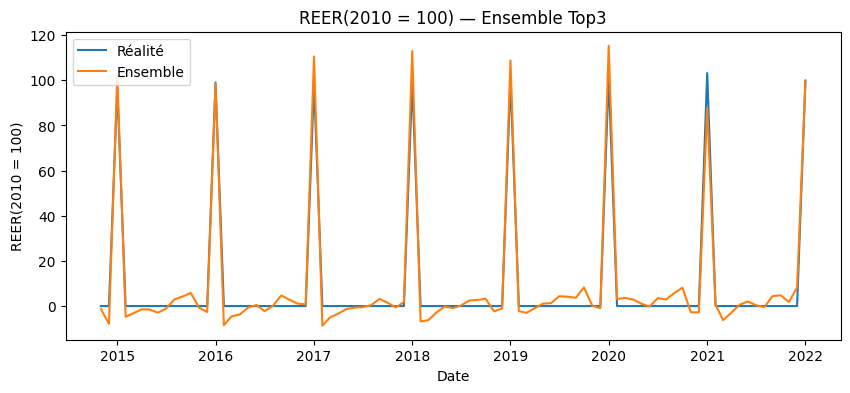

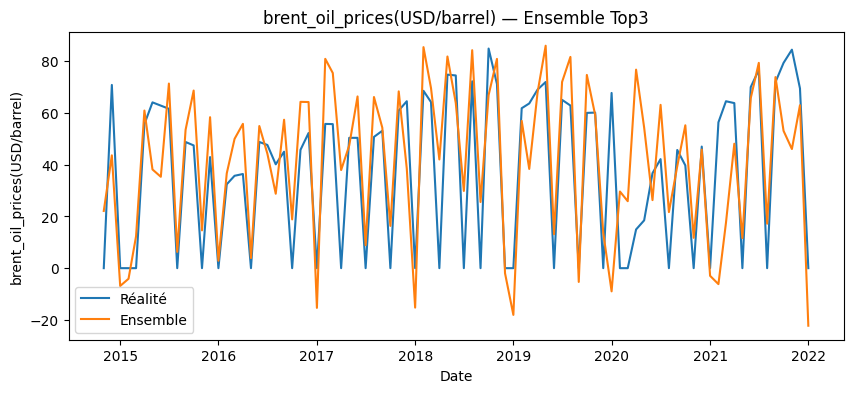

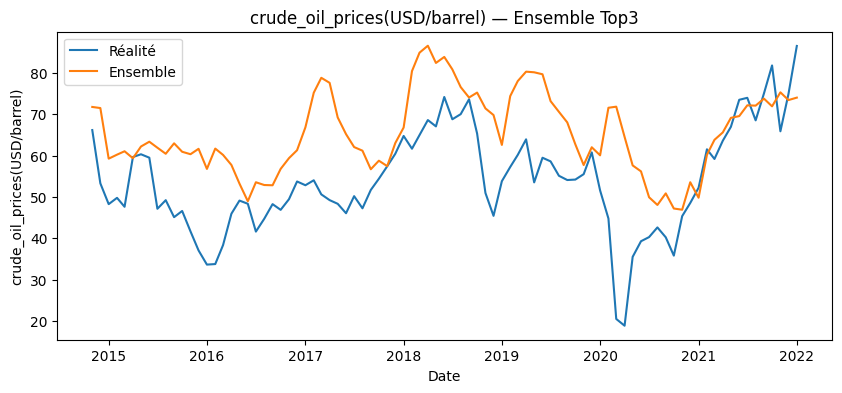

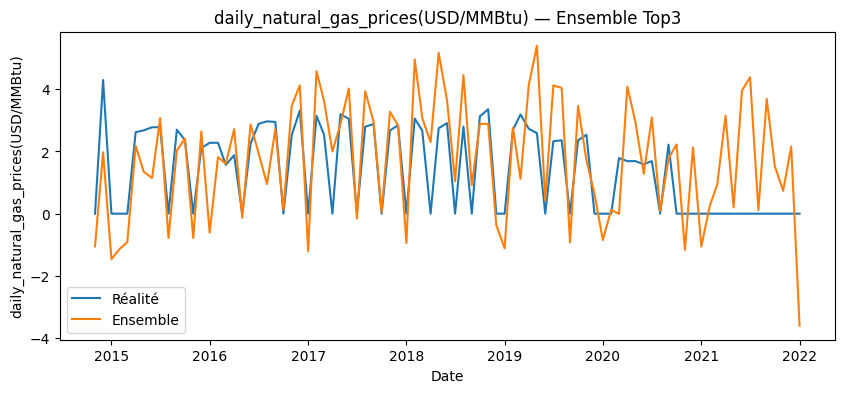

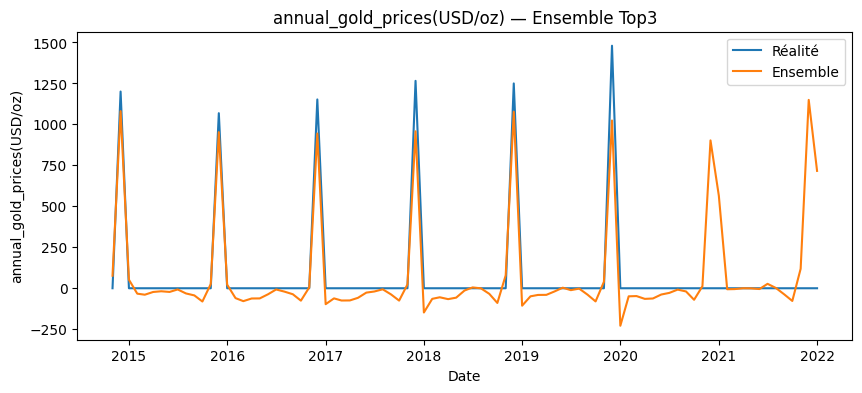

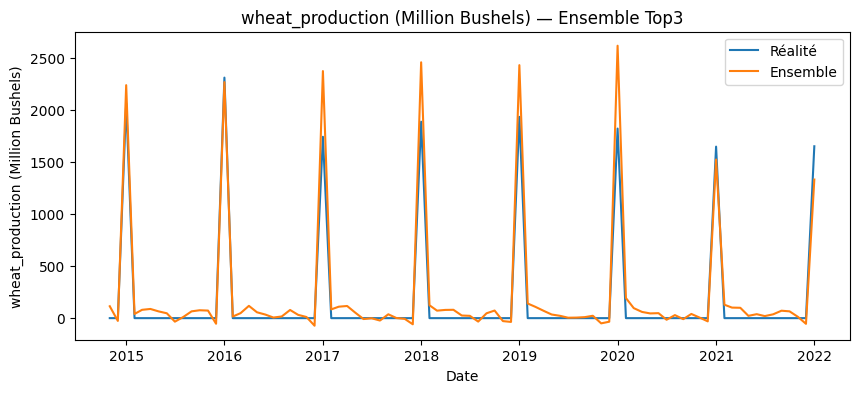

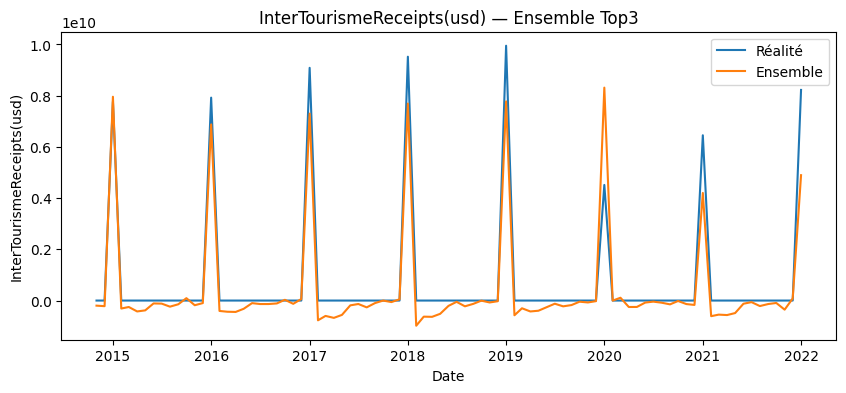

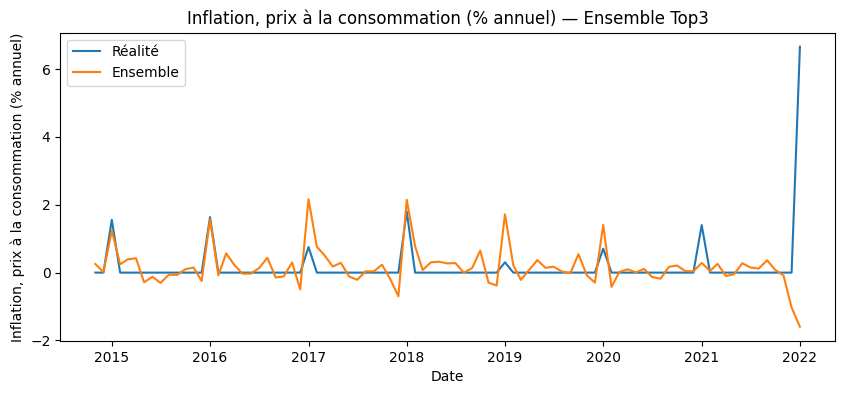

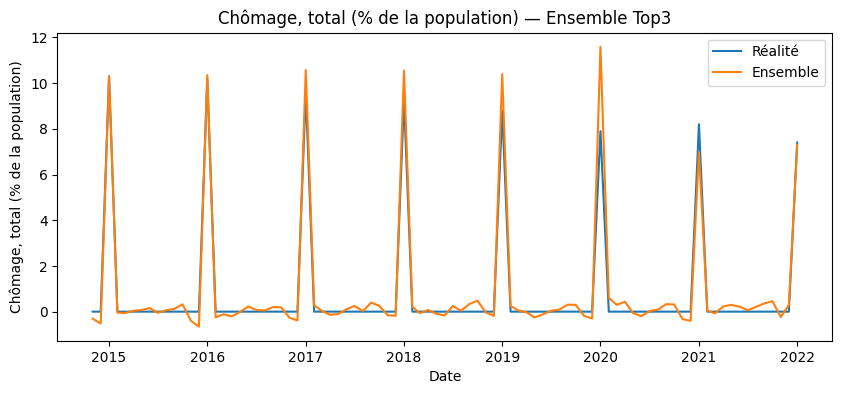

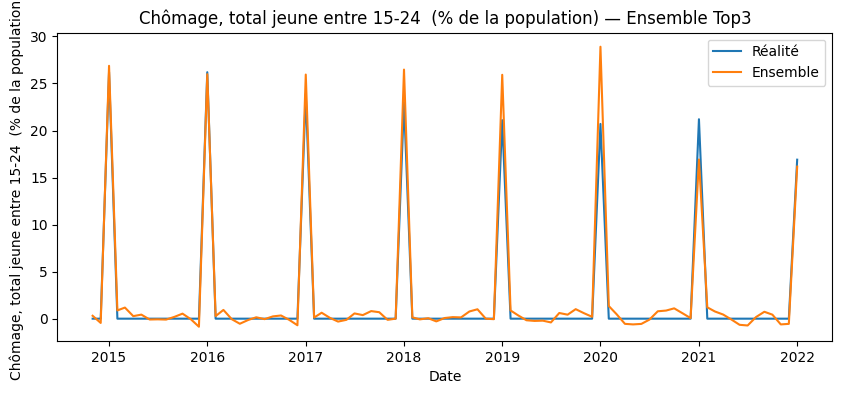

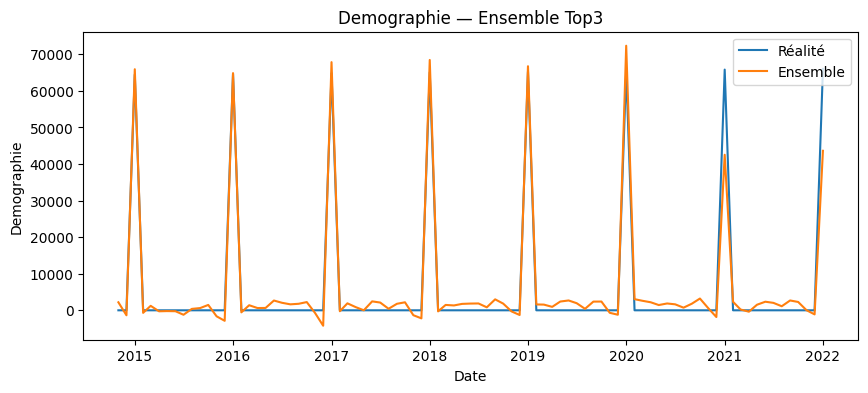

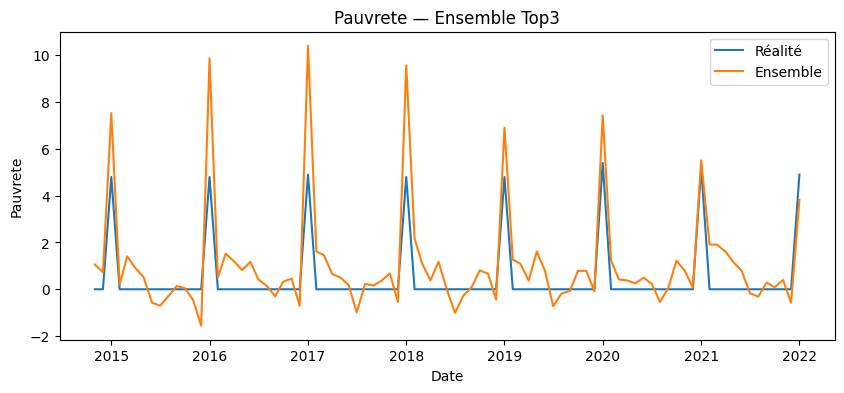

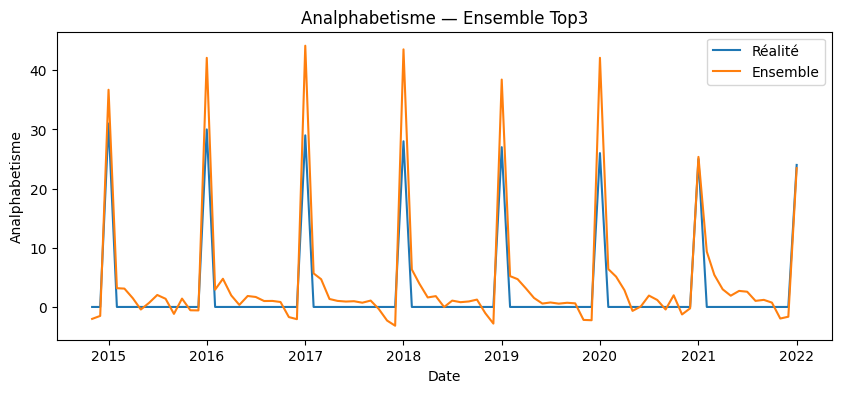

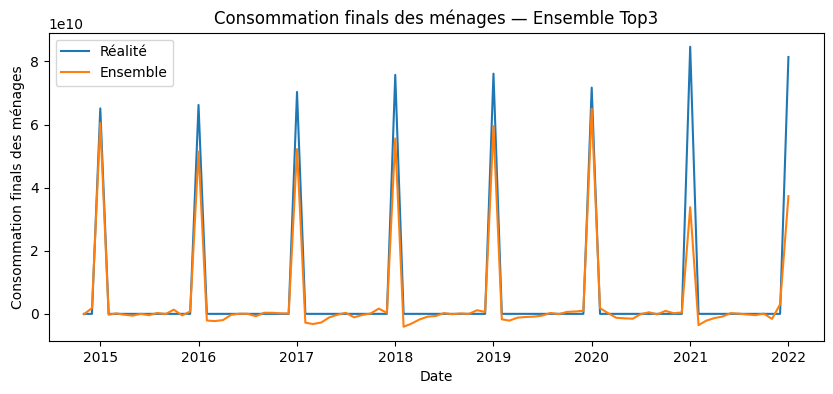

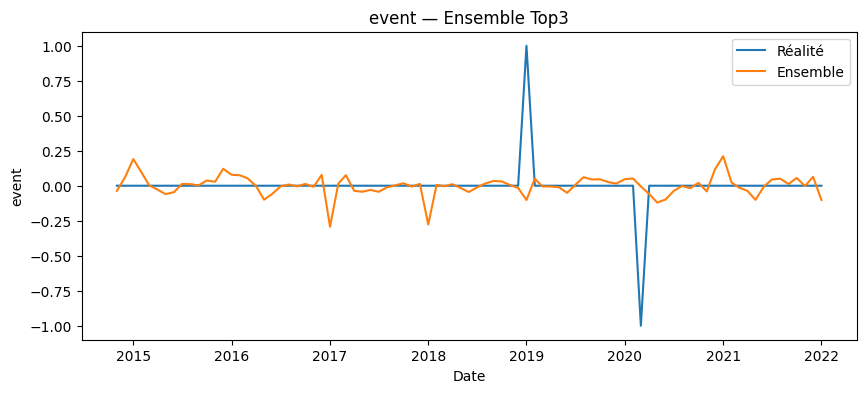

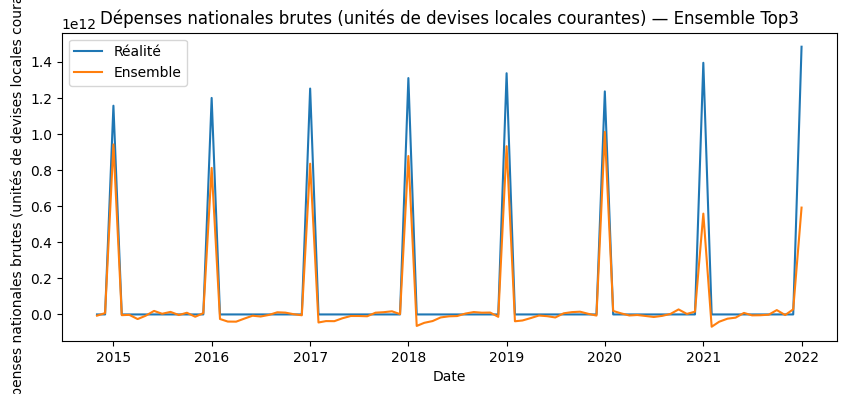

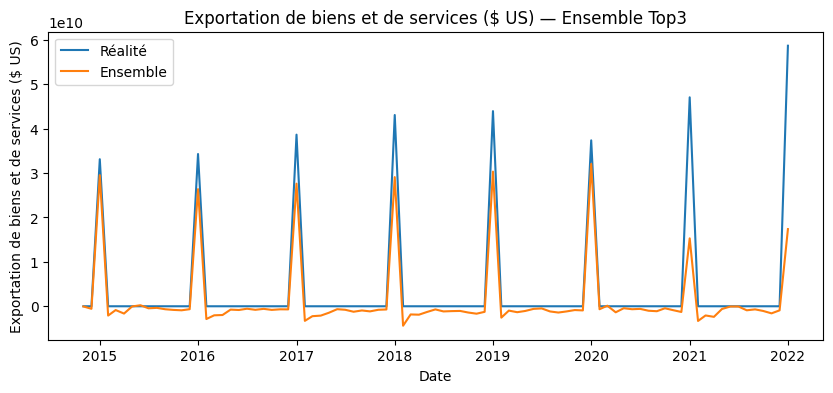

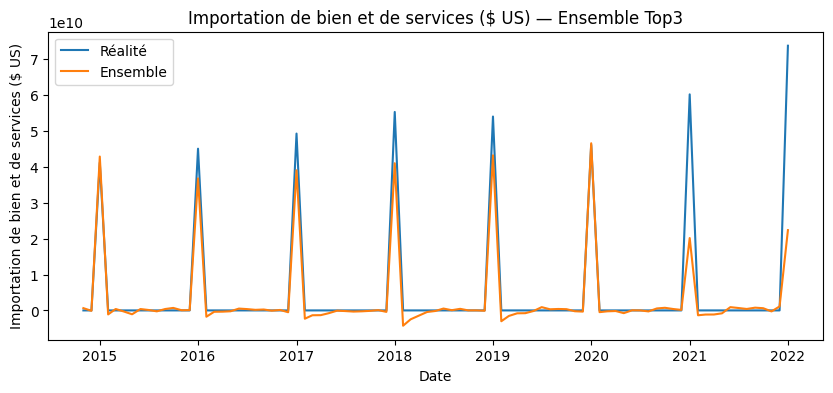

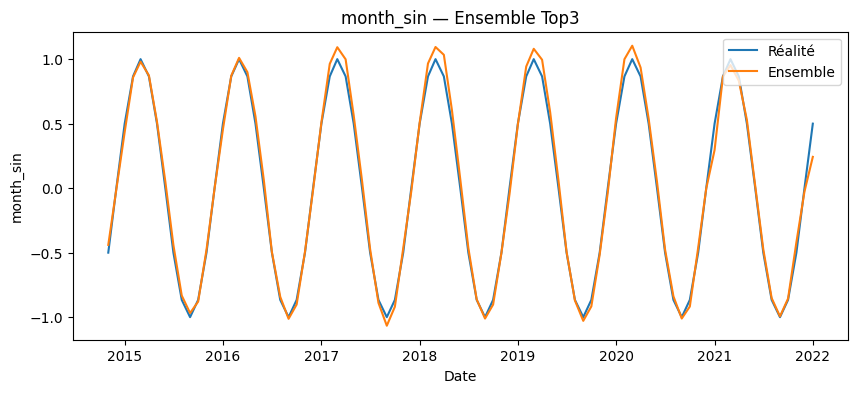

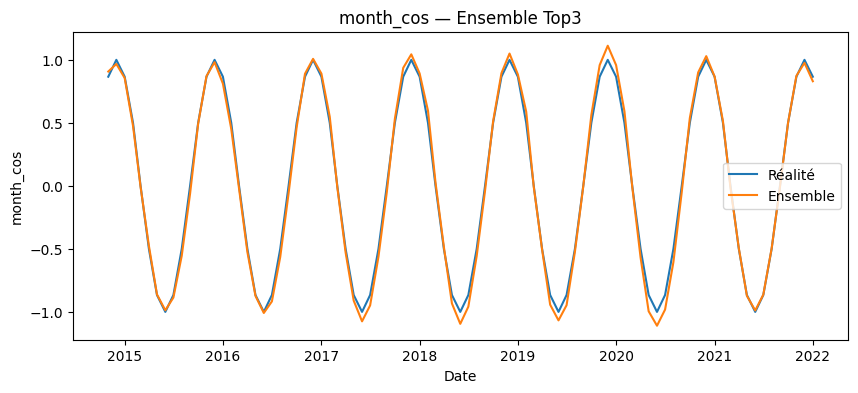

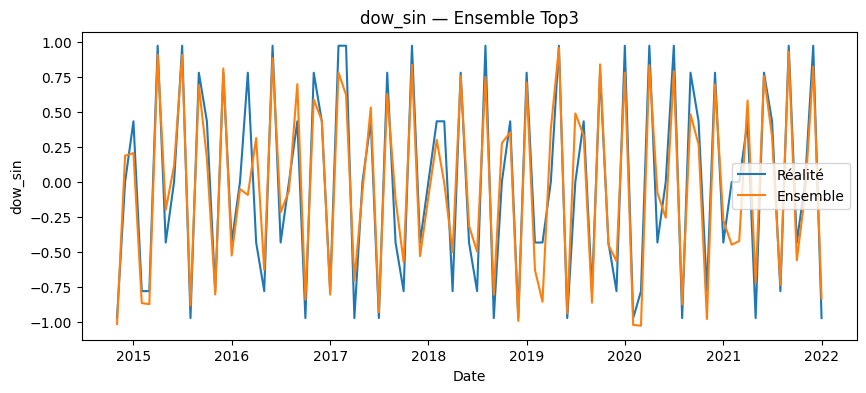

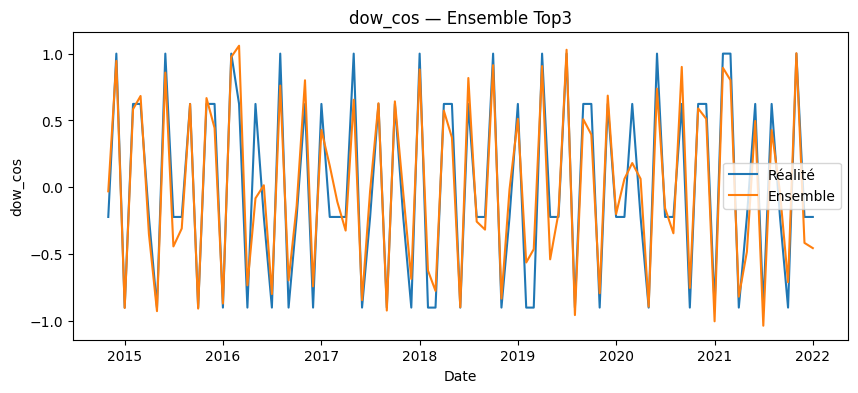

In [17]:
# Cell 14: Visualisation des prédictions de l’ensemble
dates_test = test_df.index
for i, col in enumerate(df.columns):
    plt.figure(figsize=(10, 4))
    plt.plot(dates_test, y_true[:, i], label="Réalité")
    plt.plot(dates_test, preds[:, i], label="Ensemble")
    plt.title(f"{col} — Ensemble Top3")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()
